# Библиотеки

In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

## Сначала решаем ОДУ Эйлером

In [2]:
def euler_solve(h, t, t_last, f, maxh = 0.05):
    n_steps = math.ceil(abs(t_last - t) / maxh)

    time_step = (t_last - t)/n_steps
    for i in range(n_steps):
        h = h + time_step * f(h, t) 
        t = t + time_step
    return h

Теперь рассмотрим прямое и обратное распространнеие в ОДУ

In [3]:
class MYF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        batch_size = z.shape[0]
        out = self.forward(z, t)
        a = grad_outputs
        dz, dt, *dp = torch.autograd.grad((out,), (z, t) + tuple(self.parameters()), grad_outputs=(a), allow_unused=True)
        dp = torch.cat([p_grad.flatten() for p_grad in dp]).unsqueeze(0)
        dp = dp.expand(batch_size, -1) / batch_size
        if dt is not None:
          dt = dt.expand(batch_size, 1) / batch_size
        return out, dz, dt, dp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

class Adjoint(torch.autograd.Function):
    @staticmethod
    def forward(args, z0, t, flat_parameters, func):
        assert isinstance(func, MYF)
        bs, *z_shape = z0.size()
        with torch.no_grad():
            z = torch.zeros(t.size(0), bs, *z_shape).to(z0)
            z[0] = z0
            for i in range(t.size(0) - 1):
                z0 = euler_solve(z0, t[i], t[i + 1], func)
                z[i + 1] = z0

        args.func = func
        args.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(args, dLdz):

        func = args.func
        t, z, flat_parameters = args.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        def augmented_dynamics(aug_z_i, t_i):
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)

                faug = func.forward_with_grad(z_i, t_i, grad_outputs=a)
                func_eval, dz, dt, dp = faug

                dz = dz if dz is not None else torch.zeros(bs, *z_shape)
                dp = dp if dp is not None else torch.zeros(bs, n_params)
                dt = dt if dt is not None else torch.zeros(bs, 1)
                dz = dz.to(z_i)
                dp = dp.to(z_i)
                dt = dt.to(z_i)
            func_eval = func_eval.view(bs, n_dim)
            adfdz = dz.view(bs, n_dim) 
            return torch.cat((func_eval, -dz, -dp, -dt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)
        with torch.no_grad():
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                aug_ans = euler_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Обернем всё в классы

In [4]:
class HelperClass(nn.Module):
    def __init__(self, func):
        super(HelperClass, self).__init__()
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = Adjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Интерполяция

In [5]:
class Linearlayer(MYF):
    def __init__(self, W):
        super(Linearlayer, self).__init__()
        self.linear_layer = nn.Linear(2, 2, bias=False)
        self.linear_layer.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.linear_layer(x)

class SpiralFunctionExample(Linearlayer):
    def __init__(self):
        matrix = Tensor([[-0.1, -1.], [1., -0.1]])
        super(SpiralFunctionExample, self).__init__(matrix)

class RandomParams(Linearlayer):
    def __init__(self):
        super(RandomParams, self).__init__(torch.randn(2, 2)/2.)


class Test(MYF):
    def __init__(self, A, B, x0):
        super(Test, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

class DynamicsBlock(MYF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(DynamicsBlock, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.linear_layer1 = nn.Linear(in_dim, hid_dim)
        else:
            self.linear_layer1 = nn.Linear(in_dim+1, hid_dim)
        self.linear_layer2 = nn.Linear(hid_dim, hid_dim)
        self.linear_layer3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.linear_layer1(x))
        h = self.elu(self.linear_layer2(h))
        out = self.linear_layer3(h)
        return out

def to_np(x):
    return x.detach().cpu().numpy()

def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0])
    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)

    plt.show()


## Test 

In [6]:
def test_out(true, trained, n_steps, plot_freq=10):
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 5*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(
                  index_np[(times_np > t0) & (times_np < t1)]
              )[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    optimizer = torch.optim.Adam(trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = trained(z0, times, return_whole_sequence=True)
            print("Epoch:", i)
            plot_trajectories(obs=[obs], times=[times], trajs=[z_p])
            clear_output(wait=True)

Examples

Epoch: 0


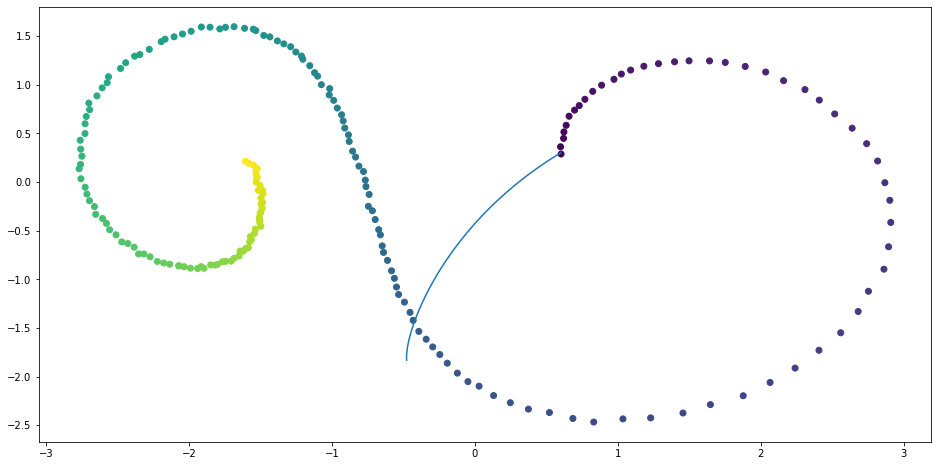

In [7]:
true = HelperClass(SpiralFunctionExample())
trained = HelperClass(RandomParams())


func = Test(Tensor([[-0.1, -0.5], [0.5, -0.1]]), 
            Tensor([[0.2, 1.], [-1, 0.2]]), 
            Tensor([[-1., 0.]]))

true = HelperClass(func)

func = DynamicsBlock(2, 16, time_invariant=True)

trained = HelperClass(func)

test_out(true, trained, 1, plot_freq = 1)

# PREY-PREDATOR

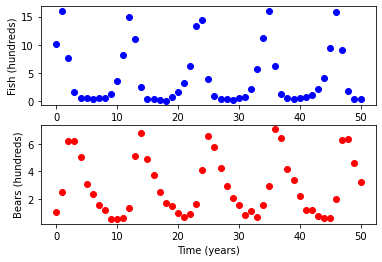

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys

y0 = [10,1]

t = np.linspace(0,50,num=1001)

alpha = 1.1

beta = 0.4
delta = 0.1
gamma = 0.4


params = [alpha, beta, delta, gamma]

def sim(variables, t, params):
    x = variables[0]
    y = variables[1]


    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y

    return([dxdt, dydt])


y = odeint(sim, y0, t, args=(params,))


data_t = []
data_fish = []
data_bears = []

for i in range(t.shape[0]):

    if i%20==0:
        data_t.append(t[i])
        data_fish.append(np.random.normal(loc=y[i,0], scale=0.2,))
        data_bears.append(np.random.normal(loc=y[i,1], scale=0.2,))


f,(ax1,ax2) = plt.subplots(2)

line1 = ax1.scatter(data_t,data_fish, c="b")
line2 = ax2.scatter(data_t,data_bears, c="r")

ax1.set_ylabel("Fish (hundreds)")
ax2.set_ylabel("Bears (hundreds)")
ax2.set_xlabel("Time (years)")

plt.show()

f = open('pop_data.csv', "w")

f.write("year,fish_hundreds,bears_hundreds\n")

for i in range(len(data_t)):
    f.write("%s,%s,%s\n" % (data_t[i],data_fish[i],data_bears[i]))

f.close()

# Fit data

[0.87364673 0.31283142 0.1143632  0.48225496]


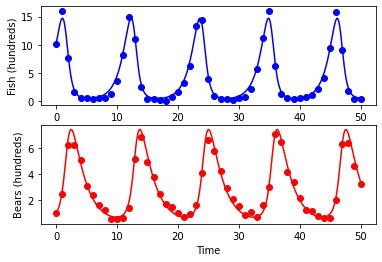

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy.optimize
from scipy.integrate import odeint

years = []
fish_pop = []
bears_pop = []

with open("pop_data.csv") as file:

    reader = csv.reader(file, delimiter=',')
    next(reader)

    for row in reader:
        years.append(float(row[0]))
        fish_pop.append(float(row[1]))
        bears_pop.append(float(row[2]))


f,(ax1,ax2) = plt.subplots(2)

line1 = ax1.scatter(years,fish_pop, c="b")
line2 = ax2.scatter(years,bears_pop, c="r")

ax1.set_ylabel("Fish (hundreds)")
ax2.set_ylabel("Bears (hundreds)")
ax2.set_xlabel("Time")

def sim(variables, t, params):
    x = variables[0]
    y = variables[1]
    
    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y

    return([dxdt, dydt])


def loss_function(params, years,fish_pop, bears_pop):

    y0 = [fish_pop[0], bears_pop[0]]

    t = np.linspace(years[0], years[-1], num=len(years))

    output = odeint(sim, y0, t, args=(params,))

    loss = 0

    for i in range(len(years)):
        data_fish = fish_pop[i]
        model_fish = output[i,0]

        data_bears = bears_pop[i]
        model_bears = output[i,1]

        res = (data_fish - model_fish)**2 + (data_bears - model_bears)**2

        loss += res

    return(loss)


params0 = np.array([1,1,1,1])
minimum = scipy.optimize.fmin(loss_function, params0, args=(years,fish_pop, bears_pop))

print(minimum)

alpha_fit = minimum[0]
beta_fit = minimum[1]
delta_fit = minimum[2]
gamma_fit = minimum[3]

params = [alpha_fit, beta_fit, delta_fit, gamma_fit]

y0 = [fish_pop[0], bears_pop[0]]

t = np.linspace(years[0], years[-1], num=1000)
output = odeint(sim, y0, t, args=(params,))

line1, = ax1.plot(t,output[:,0], color="b")
line2, = ax2.plot(t,output[:,1], color="r")

ax1.set_ylabel("Fish (hundreds)")
ax2.set_ylabel("Bears (hundreds)")
ax2.set_xlabel("Time")

plt.show()

# RNN

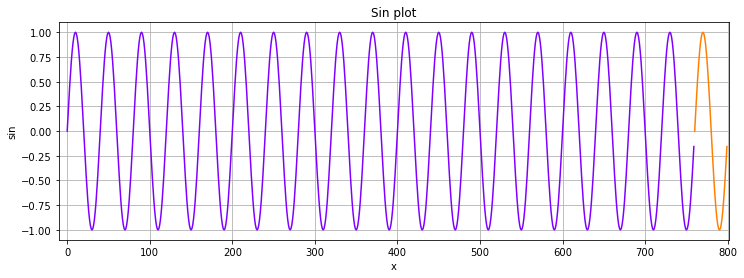

In [10]:
x = torch.linspace(0,799,800)
y = torch.sin(x*2*3.1416/40)
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(train_set.numpy(),color='#8000ff')
plt.plot(range(760,800),test_set.numpy(),color="#ff8000")
plt.show()

In [11]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

720

In [12]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [13]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Epoch 0 Loss: 0.09212874621152878
Performance on test range: 0.6071590185165405


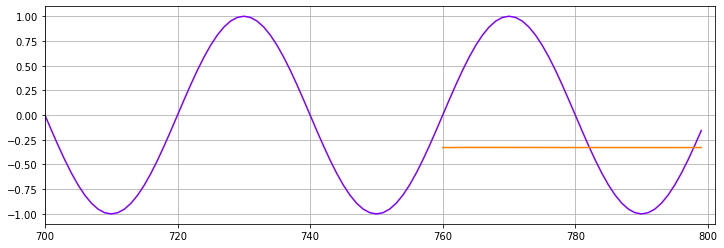

Epoch 1 Loss: 0.06506764143705368
Performance on test range: 0.5650987029075623


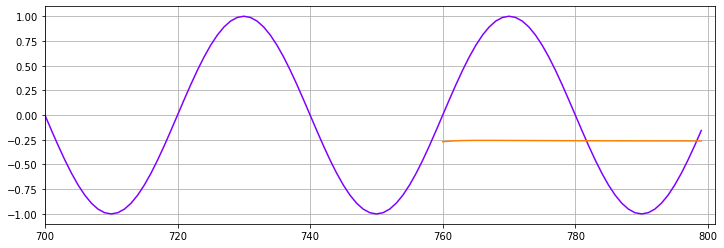

Epoch 2 Loss: 0.041980478912591934
Performance on test range: 0.5199716687202454


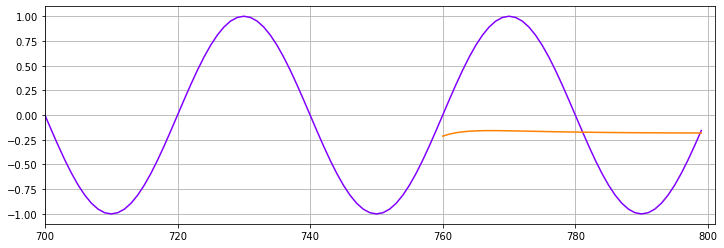

Epoch 3 Loss: 0.017842771485447884
Performance on test range: 0.42209967970848083


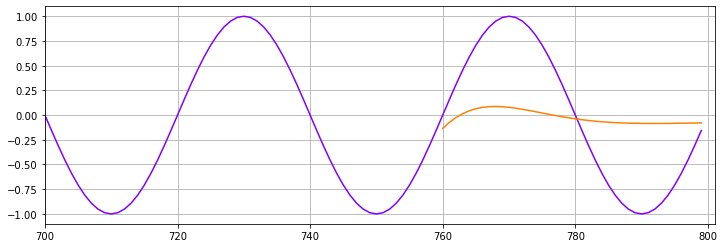

Epoch 4 Loss: 0.0028870967216789722
Performance on test range: 0.16624122858047485


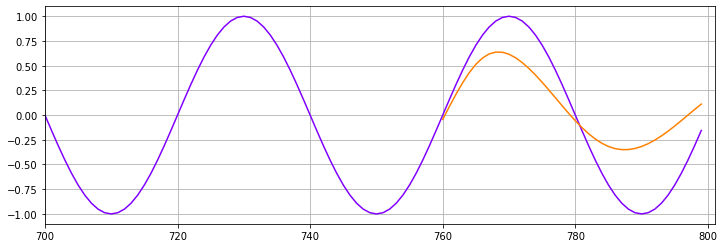

Epoch 5 Loss: 0.00032007633126340806
Performance on test range: 0.03055441752076149


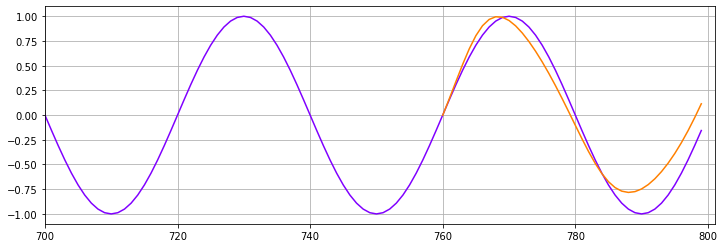

Epoch 6 Loss: 0.00012969104864168912
Performance on test range: 0.014990213327109814


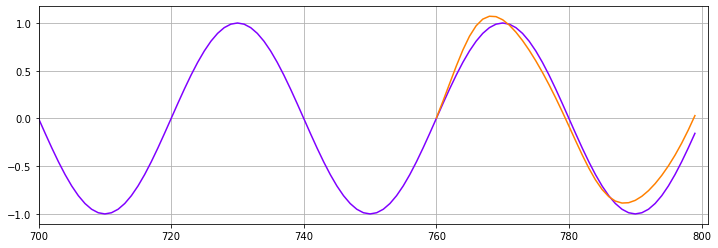

Epoch 7 Loss: 0.00012006766337435693
Performance on test range: 0.01185666024684906


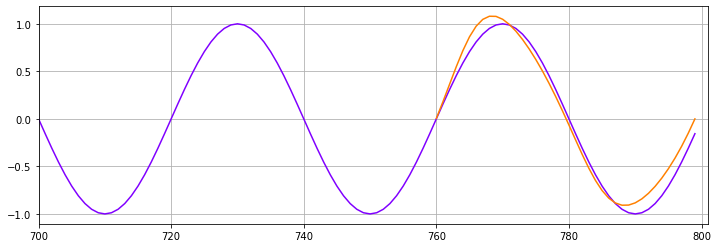

Epoch 8 Loss: 0.0001265565661014989
Performance on test range: 0.010163784958422184


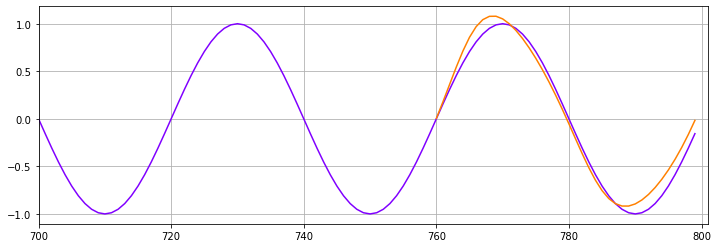

Epoch 9 Loss: 0.0001319547591265291
Performance on test range: 0.008897580206394196


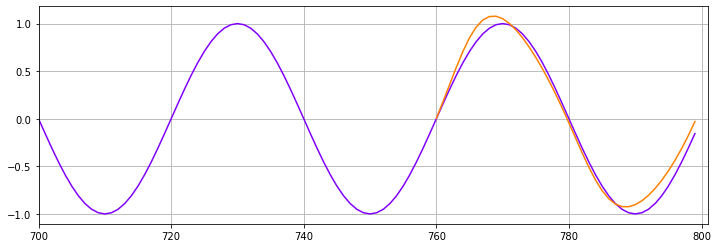

In [14]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()